In [1]:
using QuantumCumulants
using MAT
using ModelingToolkit, OrdinaryDiffEq
using Plots
using DifferentialEquations
IJulia.qtconsole()

Process(`/usr/local/bin/jupyter qtconsole --existing /home/andreas/.local/share/jupyter/runtime/kernel-e6f54b58-512c-48d5-b4db-d6afea0aa880.json`, ProcessRunning)

In [2]:
file = matopen("/home/andreas/Physics/julia/parameter.mat")
gs = read(file, "gs")
pdf = read(file, "pdf")
gperp = read(file, "gperp")
gpar = read(file, "gpar")
deltac = read(file, "deltac")
init = read(file, "init")
dr = read(file, "eta")
kappadat = read(file, "kappa")
tpump = read(file, "tpump")
tdecay = read(file, "tdecay")
spins = read(file, "spins")
firstord = read(file, "firstord")
secondord = read(file, "secondord")
tplotdat = read(file, "tplot")
deltas = spins*2*pi .+deltac
close(file)

In [3]:
# Parameters
N =length(spins) #number of atoms
M = 2
kappa, n, Δ, ilist, qlist, gamma_par, etap, gamma_perp, eta =
    cnumbers("κ ñ Δ_c I(t) Q(t) γ_{∥} ηp γ_{⊥} η")

wf, G, kappa_f = cnumbers("Δ_f G κ_f")


g(j) = cnumbers(Symbol("g_{$j}"))[1]
Δs(j) = cnumbers(Symbol("Δ_{$j}"))[1]

# Hilbertspace
hf = FockSpace(:cavity)
hfilter = FockSpace(:cavity)
ha = ⊗([NLevelSpace(Symbol(:atom, i), 2) for i = 1:N]...)
h = hf ⊗ ha;

In [4]:
# Operators
@qnumbers a::Destroy(h)
#b = Destroy(h, :b, 7)
sigma(i, j, k) = Transition(h,Symbol("σ_{$k}"),i,j,k+1)
sigmaz(k) = sigma(2, 2, k) - sigma(1, 1, k)
sigmap(k) = sigma(2, 1, k)
sigmam(k) = sigma(1, 2, k)

sigmam (generic function with 1 method)

In [5]:
H = Δ * a'a + 1im * ilist * (a' - a) + qlist * (a' + a)
for j = 1:N
    H += Δs(j) / 2 * sigmaz(j) + 1im * g(j) * (a' * sigmam(j) - a * sigmap(j))
end
#filter resonator
#H += wf*b'b+G*(a'b+b'a)

In [6]:
# Collapse operators

rates = Any[2*(n+1)*kappa, 2*n*kappa]
rates = append!(rates, [gamma_par * (n + 1) for i = 1:N])
rates = append!(rates, [n * gamma_par + etap for i = 1:N])
rates = append!(rates, [gamma_perp / 2 for i = 1:N])
#filter resonator
#rates = append!(rates, [2*kappa_f])



J = Any[a, a']
J = append!(J, [sigmam(i) for i = 1:N])
J = append!(J, [sigmap(i) for i = 1:N])
J = append!(J, [sigmaz(i) for i = 1:N])
#filter resonator
#J = append!(J, [b]);

In [7]:
p0 = [ilist => dr, etap => 0, gamma_par => gpar, [Δs(j) => deltas[j] for j=1:N]..., [g(i) => gs[i] for i=1:N]..., gamma_perp => gperp, n=> 0, qlist => 0, Δ => deltac, kappa=>kappadat];

In [8]:
opst = [a, a'a, a*a]
opst = append!(opst, [a*sigmam(i) for i = 1:N])
opst = append!(opst, [a'*sigmam(i) for i = 1:N])
opst = append!(opst, [a*sigmaz(i) for i = 1:N])
opst = append!(opst, [sigmam(i) for i = 1:N])
opst = append!(opst, [sigmaz(i) for i = 1:N])
opst = append!(opst, [sigmam(i)sigmam(j) for i = 1:N for j=i:N if i!=j])
opst = append!(opst, [sigmam(i)sigmap(j) for i = 1:N for j=i:N if i!=j])

for i=1:N
    for j=1:N
        if i!=j
        opst = append!(opst, [sigmaz(i)sigmam(j)])
        end
    end
end


opst = append!(opst, [sigmaz(i)sigmaz(j) for i = 1:N for j=i:N if i!=j])


ops = [a, a'a, a*a]
ops = append!(ops, [a*sigmam(i) for i = 1:N])
ops = append!(ops, [a'*sigmam(i) for i = 1:N])
ops = append!(ops, [a*sigma(2,2,i) for i = 1:N])
ops = append!(ops, [sigmam(i) for i = 1:N])
ops = append!(ops, [sigma(2,2,i) for i = 1:N])

eqns = meanfield(ops, H, J; rates = rates, order = M);
me_comp = complete(eqns);


eqnst = meanfield(opst, H, J; rates = rates, order = M);

In [9]:
rt = Symbolics.substitute(eqnst, tuple(p0))
@named sys = ODESystem(me_comp)

Model sys with 53 equations
States (53):
  var"⟨a⟩"(t)
  var"⟨a′*a⟩"(t)
  var"⟨a*a⟩"(t)
  var"⟨a*σ_{1}12⟩"(t)
  var"⟨a*σ_{2}12⟩"(t)
  var"⟨a*σ_{3}12⟩"(t)
⋮
Parameters (16):
  Δ_c
  ñ
  var"Q(t)"
  var"g_{2}"
  var"g_{3}"
  var"I(t)"
⋮

In [10]:
#IJulia.qtconsole()
u0 = zeros(ComplexF64, (length(me_comp)))
#u0[N*4+4:N*5+4-1] .= 1. + 0im
prob = ODEProblem(sys,u0,(tpump[1], last(tpump)+last(tdecay)), p0, jac=true);

In [11]:
function affect!(integrator)
    integrator.p[6] = 0.;
end
cb_variant2 = PresetTimeCallback(last(tpump),affect!);

# Solve
sol = solve(prob, Tsit5(), callback = cb_variant2);

In [12]:
ops = a
eqns1 = meanfield(ops, H, J; rates = rates, order = 1);
me_comp1 = complete(eqns1);
@named sys1 = ODESystem(me_comp1)
u01 = zeros(ComplexF64, (length(me_comp1)))
#u01[N*2-2:N*3-3] .= 1. + 0im
prob1 = ODEProblem(sys1,u01,(tpump[1], last(tpump)+last(tdecay)), p0);

# Solve
sol1 = solve(prob1, Tsit5(), callback = cb_variant2);

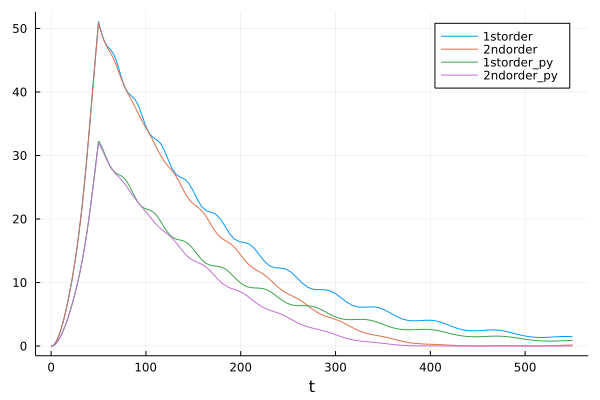

In [13]:
a2 = abs2.(sol[a])
a21 = abs2.(sol1[a])
fo = transpose(firstord)[:]
so = transpose(secondord)[:]

tp = transpose(tplotdat)[:]
plot(sol1.t*1000, a21, xlabel="t", label="1storder")
plot!(sol.t*1000, a2, xlabel="t", label="2ndorder")

plot!(tp, fo, label="1storder_py")
plot!(tp, so, label="2ndorder_py")

In [925]:
subdict = Dict([])
subdict1 = Dict([])
subdict2 = Dict([])
subdict3 = Dict([])
vec = [
    "\u2081",
    "\u2082",
    "\u2083",
    "\u2084",
    "\u2085",
    "\u2086",
    "\u2087",
    "\u2088",
    "\u2089",
]


for i = 1:N
    subs = vec[i]
    sm = "σ{$subs}⁻"
    sp = "σ{$subs}⁺"
    sz = "σ{$subs}ᶻ"


    subdict = merge!(
        subdict,
        Dict([average(a * sigmam(i)) => Parameter(Symbol("⟨a" * sm * "⟩"))]),
    )
    subdict = merge!(
        subdict,
        Dict([average(a' * sigmam(i)) => Parameter(Symbol("⟨a^†" * sm * "⟩"))]),
    )

    subdict = merge!(
        subdict,
        Dict([average(a * sigmap(i)) => Parameter(Symbol("⟨a" * sp * "⟩"))]),
    )
    subdict = merge!(
        subdict,
        Dict([average(a' * sigmap(i)) => Parameter(Symbol("⟨a^†" * sp * "⟩"))]),
    )

    subdict = merge!(
        subdict,
        Dict([
            average(a * sigma(2, 2, i)) =>
                Parameter(Symbol("⟨a" * sz * "⟩")) / 2 + average(a) / 2,
        ]),
    )
    subdict = merge!(
        subdict,
        Dict([
            average(a' * sigma(2, 2, i)) =>
                Parameter(Symbol("⟨a^†" * sz * "⟩")) / 2 + average(a') / 2,
        ]),
    )

    for k = 1:N
        subsk = vec[k]
        smk = "σ{$subsk}⁻"
        spk = "σ{$subsk}⁺"
        szk = "σ{$subsk}ᶻ"

        subdict = merge!(
            subdict,
            Dict([
                average(sigmam(k) * sigmap(i)) =>
                    Parameter(Symbol("⟨" * smk * sp * "⟩")),
            ]),
        )
        subdict = merge!(
            subdict,
            Dict([
                average(sigmap(k) * sigmap(i)) =>
                    Parameter(Symbol("⟨" * spk * sp * "⟩")),
            ]),
        )
        subdict = merge!(
            subdict,
            Dict([
                average(sigmap(k) * sigmam(i)) =>
                    Parameter(Symbol("⟨" * spk * sm * "⟩")),
            ]),
        )
        subdict = merge!(
            subdict,
            Dict([
                average(sigmam(k) * sigmam(i)) =>
                    Parameter(Symbol("⟨" * smk * sm * "⟩")),
            ]),
        )

        subdict = merge!(
            subdict,
            Dict([
                average(sigma(2, 2, k) * sigmap(i)) =>
                    Parameter(Symbol("⟨" * szk * sp * "⟩")) / 2 +
                    Parameter(Symbol("⟨" * sp * "⟩")) / 2,
            ]),
        )
        subdict = merge!(
            subdict,
            Dict([
                average(sigma(2, 2, k) * sigmam(i)) =>
                    Parameter(Symbol("⟨" * szk * sm * "⟩")) / 2 +
                    Parameter(Symbol("⟨" * sm * "⟩")) / 2,
            ]),
        )

        subdict = merge!(
            subdict,
            Dict([
                average(sigmap(k) * sigma(2, 2, i)) =>
                    Parameter(Symbol("⟨" * spk * sz * "⟩")) / 2 +
                    Parameter(Symbol("⟨" * spk * "⟩")) / 2,
            ]),
        )
        subdict = merge!(
            subdict,
            Dict([
                average(sigmam(k) * sigma(2, 2, i)) =>
                    Parameter(Symbol("⟨" * smk * sz * "⟩")) / 2 +
                    Parameter(Symbol("⟨" * smk * "⟩")) / 2,
            ]),
        )

        subdict = merge!(
            subdict,
            Dict([
                average(sigma(2, 2, k) * sigma(2, 2, i)) =>
                    1 / 4 * (
                        Parameter(Symbol("⟨" * szk * sz * "⟩")) +
                        Parameter(Symbol("⟨" * sz * "⟩")) +
                        Parameter(Symbol("⟨" * szk * "⟩")) +
                        1
                    ),
            ]),
        )
    end

    subdict =
        merge!(subdict, Dict([average(sigmam(i)) => Parameter(Symbol("⟨" * sm * "⟩"))]))
    subdict =
        merge!(subdict, Dict([average(sigmap(i)) => Parameter(Symbol("⟨" * sp * "⟩"))]))
    subdict = merge!(
        subdict,
        Dict([average(sigma(2, 2, i)) => (Parameter(Symbol("⟨" * sz * "⟩")) / 2) + 1 / 2]),
    )


    
end


eqnst = SymbolicUtils.simplify(Symbolics.substitute(eqnst, subdict2), expand = true)

eq_nt = SymbolicUtils.simplify(Symbolics.substitute(eqnst, subdict), expand = true)

∂ₜ(⟨a⟩) = var"I(t)" + (0.0 - 1.0im)*var"Q(t)" + var"g_{1}"*var"⟨σ{₁}⁻⟩" + var"g_{2}"*var"⟨σ{₂}⁻⟩" + var"g_{3}"*var"⟨σ{₃}⁻⟩" + var"g_{4}"*var"⟨σ{₄}⁻⟩" + (0.0 - 1.0im)*Δ_c*⟨a⟩ + -κ*⟨a⟩
∂ₜ(⟨a′*a⟩) = var"g_{1}"*(var"⟨a^†σ{₁}⁻⟩" + var"⟨aσ{₁}⁺⟩") + var"I(t)"*(⟨a′⟩ + ⟨a⟩) + var"g_{2}"*(var"⟨a^†σ{₂}⁻⟩" + var"⟨aσ{₂}⁺⟩") + var"g_{3}"*(var"⟨a^†σ{₃}⁻⟩" + var"⟨aσ{₃}⁺⟩") + var"g_{4}"*(var"⟨a^†σ{₄}⁻⟩" + var"⟨aσ{₄}⁺⟩") + (2.0 + 0.0im)ñ*κ + (0.0 - 1.0im)*var"Q(t)"*⟨a′⟩ + (0.0 + 1.0im)*var"Q(t)"*⟨a⟩ + (-2.0 + 0.0im)κ*⟨a′*a⟩
∂ₜ(⟨a*a⟩) = (2.0 + 0.0im)var"I(t)"*⟨a⟩ + (2.0 + 0.0im)var"g_{1}"*var"⟨aσ{₁}⁻⟩" + (2.0 + 0.0im)var"g_{2}"*var"⟨aσ{₂}⁻⟩" + (2.0 + 0.0im)var"g_{3}"*var"⟨aσ{₃}⁻⟩" + (2.0 + 0.0im)var"g_{4}"*var"⟨aσ{₄}⁻⟩" + (0.0 - 2.0im)*var"Q(t)"*⟨a⟩ + (0.0 - 2.0im)*Δ_c*⟨a*a⟩ + (-2.0 + 0.0im)κ*⟨a*a⟩
∂ₜ(var"⟨aσ{₁}⁻⟩") = var"g_{2}"*var"⟨σ{₁}⁻σ{₂}⁻⟩" + var"g_{3}"*var"⟨σ{₁}⁻σ{₃}⁻⟩" + var"g_{4}"*var"⟨σ{₁}⁻σ{₄}⁻⟩" + var"I(t)"*var"⟨σ{₁}⁻⟩" + (0.0 - 1.0im)*Δ_c*var"⟨aσ{₁}⁻⟩" + (0.0 - 1.0im)*var"Δ_{1}"*var"⟨aσ{₁}⁻⟩

In [926]:
subdict = Dict([])



  subdict = merge!(
        subdict,
        Dict([average(a) => Parameter(Symbol("x_1"))]),
    )
    subdict = merge!(
        subdict,
        Dict([average(a') => conj(Parameter(Symbol("x_1")))]),
    )
    subdict = merge!(
        subdict,
        Dict([average(a'a) => Parameter(Symbol("x_2"))]),
    )
    subdict = merge!(
        subdict,
        Dict([average(a*a) => Parameter(Symbol("x_3"))]),
    )
    ctr = 4
     for k = 1:N
    subsk = vec[k]
        smk = "σ{$subsk}⁻"
        spk = "σ{$subsk}⁺"
        szk = "σ{$subsk}ᶻ"
    
        subdict = merge!(
            subdict,
            Dict([
                Parameter(Symbol("⟨a" * smk * "⟩")) =>
                    Parameter(Symbol("x_"*string(ctr))),
            ]),
        )
        subdict = merge!(
            subdict,
            Dict([
                Parameter(Symbol("⟨a^†" * spk * "⟩")) =>
                    conj(Parameter(Symbol("x_"*string(ctr)))),
            ]),
        )
        ctr = ctr+1
    end
    
    for k = 1:N
    subsk = vec[k]
        smk = "σ{$subsk}⁻"
        spk = "σ{$subsk}⁺"
        szk = "σ{$subsk}ᶻ"
        subdict = merge!(
            subdict,
            Dict([
                Parameter(Symbol("⟨a^†" * smk * "⟩")) =>
                    Parameter(Symbol("x_"*string(ctr))),
            ]),
        )
        subdict = merge!(
            subdict,
            Dict([
                Parameter(Symbol("⟨a" * spk * "⟩")) =>
                    conj(Parameter(Symbol("x_"*string(ctr)))),
            ]),
        )
        ctr = ctr+1
    end
    
    for k = 1:N
subsk = vec[k]
        smk = "σ{$subsk}⁻"
        spk = "σ{$subsk}⁺"
        szk = "σ{$subsk}ᶻ"
        subdict = merge!(
            subdict,
            Dict([
                Parameter(Symbol("⟨a" * szk * "⟩")) =>
                    Parameter(Symbol("x_"*string(ctr))),
            ]),
        )
        subdict = merge!(
            subdict,
            Dict([
                Parameter(Symbol("⟨a^†" * szk * "⟩")) =>
                    conj(Parameter(Symbol("x_"*string(ctr)))),
            ]),
        )
        ctr = ctr+1
    end
    
    for k = 1:N
subsk = vec[k]
        smk = "σ{$subsk}⁻"
        spk = "σ{$subsk}⁺"
        szk = "σ{$subsk}ᶻ"
        subdict = merge!(
            subdict,
            Dict([
                Parameter(Symbol("⟨" * smk * "⟩")) =>
                    Parameter(Symbol("x_"*string(ctr))),
            ]),
        )
        subdict = merge!(
            subdict,
            Dict([
                Parameter(Symbol("⟨" * spk * "⟩")) =>
                    conj(Parameter(Symbol("x_"*string(ctr)))),
            ]),
        )
        ctr = ctr+1
    end
    
    
    for k = 1:N
    subsk = vec[k]
        smk = "σ{$subsk}⁻"
        spk = "σ{$subsk}⁺"
        szk = "σ{$subsk}ᶻ"
        subdict = merge!(
            subdict,
            Dict([
                Parameter(Symbol("⟨" * szk * "⟩")) =>
                    Parameter(Symbol("x_"*string(ctr))),
            ]),
        )
        ctr = ctr+1
    end
    
    for k = 1:N

        subsk = vec[k]
        smk = "σ{$subsk}⁻"
        spk = "σ{$subsk}⁺"
        szk = "σ{$subsk}ᶻ"
        for j=k:N
        if (j==k)
            continue
        end
            subsj = vec[j]
            smj = "σ{$subsj}⁻"
            spj = "σ{$subsj}⁺"
            szj = "σ{$subsj}ᶻ"
        subdict = merge!(
            subdict,
            Dict([
                Parameter(Symbol("⟨" * smk*smj * "⟩")) =>
                    Parameter(Symbol("x_"*string(ctr))),
            ]),
        )
        subdict = merge!(
            subdict,
            Dict([
                Parameter(Symbol("⟨" * spk*spj * "⟩")) =>
                    conj(Parameter(Symbol("x_"*string(ctr)))),
            ]),
        )
        if (j!=k)
        ctr = ctr+1
        end
    end
    end
    for k = 1:N

        subsk = vec[k]
        smk = "σ{$subsk}⁻"
        spk = "σ{$subsk}⁺"
        szk = "σ{$subsk}ᶻ"
        for j=k:N
                if (j==k)
            continue
        end
            subsj = vec[j]
            smj = "σ{$subsj}⁻"
            spj = "σ{$subsj}⁺"
            szj = "σ{$subsj}ᶻ"
        subdict = merge!(
            subdict,
            Dict([
                Parameter(Symbol("⟨" * smk*spj * "⟩")) =>
                    Parameter(Symbol("x_"*string(ctr))),
            ]),
        )
        subdict = merge!(
            subdict,
            Dict([
                Parameter(Symbol("⟨" * spk*smj * "⟩")) =>
                    conj(Parameter(Symbol("x_"*string(ctr)))),
            ]),
        )
                if (j!=k)
        ctr = ctr+1
        end
    end
    end

    for k = 1:N

        subsk = vec[k]
        smk = "σ{$subsk}⁻"
        spk = "σ{$subsk}⁺"
        szk = "σ{$subsk}ᶻ"
        for j=1:N
                if (j==k)
            continue
        end
            subsj = vec[j]
            smj = "σ{$subsj}⁻"
            spj = "σ{$subsj}⁺"
            szj = "σ{$subsj}ᶻ"
        subdict = merge!(
            subdict,
            Dict([
                Parameter(Symbol("⟨" * szk*smj * "⟩")) =>
                    Parameter(Symbol("x_"*string(ctr))),
            ]),
        )
        
        subdict = merge!(
            subdict,
            Dict([
                Parameter(Symbol("⟨" * smj*szk * "⟩")) =>
                    Parameter(Symbol("x_"*string(ctr))),
            ]),
        )
        
        subdict = merge!(
            subdict,
            Dict([
                Parameter(Symbol("⟨" * szk*spj * "⟩")) =>
                    conj(Parameter(Symbol("x_"*string(ctr)))),
            ]),
        )
        
        subdict = merge!(
            subdict,
            Dict([
                Parameter(Symbol("⟨" * spj*szk * "⟩")) =>
                    conj(Parameter(Symbol("x_"*string(ctr)))),
            ]),
        )
        
                if (j!=k)
        ctr = ctr+1
        end
    end
    end
    for k = 1:N

        subsk = vec[k]
        smk = "σ{$subsk}⁻"
        spk = "σ{$subsk}⁺"
        szk = "σ{$subsk}ᶻ"
        for j=k:N
                if (j==k)
            continue
        end
            subsj = vec[j]
            smj = "σ{$subsj}⁻"
            spj = "σ{$subsj}⁺"
            szj = "σ{$subsj}ᶻ"
        subdict = merge!(
            subdict,
            Dict([
                Parameter(Symbol("⟨" * szk*szj * "⟩")) =>
                    Parameter(Symbol("x_"*string(ctr))),
            ]),
        )

                if (j!=k)
        ctr = ctr+1
        end
    end
    end

In [927]:
eqtn = SymbolicUtils.simplify(Symbolics.substitute(eq_nt, subdict), expand = true);
eqtn = eqtn.equations;

rhs = [eqtn[i].rhs for i=1:length(eqtn)];
rhs[2]

var"I(t)"*(x_1 + conj(x_1)) + var"g_{1}"*(x_8 + conj(x_8)) + var"g_{2}"*(x_9 + conj(x_9)) + var"g_{3}"*(x_10 + conj(x_10)) + var"g_{4}"*(x_11 + conj(x_11)) + (0.0 + 1.0im)*var"Q(t)"*x_1 + (0.0 - 1.0im)*var"Q(t)"*conj(x_1) + (-2.0 + 0.0im)x_2*κ + (2.0 + 0.0im)ñ*κ

In [928]:
file = matopen("/home/andreas/Physics/julia/test.mat")
initrand = read(file, "init")
valspy = transpose(read(file, "vals"))[:]
close(file)

In [929]:
subdictn = Dict([])

for ctr=1:length(rhs)
    subdictn = merge!(
            subdictn,
            Dict([
                Parameter(Symbol("x_"*string(ctr))) =>
                    transpose(initrand)[:][ctr],
            ])
        )
end

subdictcust = Dict([qlist => 0., etap=>0, ilist=>eta, n=>0])
subdictcust2 = Dict([eta=>dr])


res = [SymbolicUtils.substitute(rhs[i], subdictcust) for i=1:length(rhs)];
res = [SymbolicUtils.substitute(res[i], subdictcust2) for i=1:length(rhs)];
res = [SymbolicUtils.substitute(res[i], subdictn) for i=1:length(rhs)];
res = [SymbolicUtils.substitute(res[i], p0) for i=1:length(rhs)];

diff = res-valspy;

res2 = [SymbolicUtils.substitute(rhs[i], subdictcust) for i=1:length(rhs)];
res2 = [SymbolicUtils.substitute(res2[i], subdictcust2) for i=1:length(rhs)];
#res2 = [SymbolicUtils.substitute(res2[i], subdictn) for i=1:length(rhs)];
#res2 = [SymbolicUtils.substitute(res2[i], p0) for i=1:length(rhs)];

res2[36]

var"g_{2}"*x_12*x_21 + var"g_{2}"*x_13*x_20 + var"g_{2}"*x_1*x_48 + -x_17*var"γ_{∥}" + var"g_{1}"*x_17*((-2.0 + 0.0im)x_8 + (-2.0 + 0.0im)conj(x_8)) + (0.0 - 1.0im)*x_36*var"Δ_{2}" + (-1.5 + 0.0im)x_36*var"γ_{∥}" + -x_36*var"γ_{⊥}" + (-2.0 + 0.0im)var"g_{1}"*x_1*conj(x_30) + (-2.0 + 0.0im)var"g_{1}"*x_16*x_9 + (-2.0 + 0.0im)var"g_{1}"*x_24*conj(x_1) + (-2.0 + 0.0im)var"g_{1}"*x_5*conj(x_16) + (4.0 + 0.0im)var"g_{1}"*x_16*x_17*conj(x_1) + (4.0 + 0.0im)var"g_{1}"*x_1*x_17*conj(x_16) + (-2.0 + 0.0im)var"g_{2}"*x_1*x_20*x_21

In [933]:
diff

53-element Vector{ComplexF64}:
  1.4210854715202004e-14 + 0.0im
  -2.842170943040401e-14 + 0.0im
   2.842170943040401e-14 + 0.0im
   2.842170943040401e-14 - 4.440892098500626e-16im
  1.4210854715202004e-14 + 0.0im
  -2.842170943040401e-14 - 1.4210854715202004e-14im
                     0.0 + 0.0im
   7.105427357601002e-15 - 3.552713678800501e-15im
                     0.0 - 1.4210854715202004e-14im
  -2.842170943040401e-14 + 0.0im
   2.842170943040401e-14 - 2.842170943040401e-14im
   8.881784197001252e-16 + 8.881784197001252e-16im
  -3.552713678800501e-15 - 1.3766765505351941e-14im
                         ⋮
                     0.0 + 0.0im
  -7.105427357601002e-15 + 1.4210854715202004e-14im
                     0.0 - 2.842170943040401e-14im
                     0.0 + 0.0im
                     0.0 + 3.552713678800501e-15im
                     0.0 + 0.0im
 -1.4210854715202004e-14 - 8.881784197001252e-16im
                     0.0 - 4.3298697960381105e-15im
  -5.551115123125783e-16 + 1